In [1]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt
from meep.materials import LiNbO3
from meep import mpb
mp.verbosity(0)


1

In [19]:
a = 0.775
r,h,wl, = 0.315*a,0.3,1.55
x_num,y_num = 50,6
resolution,courant = 10,0.1
fcen,nfreq= 1/wl,10
df = 0.1*fcen
pml = 0.5*wl

def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b

wg_wight = y_num*np.sqrt(3)*a*2
LN = mp.Medium(epsilon_diag=(lno(wl),lne(wl),lno(wl)))

def add_cylinder(local):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a

In [20]:


block_x,block_y,block_z=0,0,0
Block_x,Block_y,Block_z=x_num*a,wg_wight,h


x_length = 3 
y_length = np.sqrt(3)*a
z_length = h
block_x1= -x_num*0.5*a-x_length*0.5
block_x2= -block_x1

soc_wight,soc_hight=np.sqrt(3)*a*2,3*h
sources_area=mp.Vector3(0,soc_wight,soc_hight)
soc_local=mp.Vector3(-0.5*a*x_num-x_length*0.5,0,0)


minitor_size=sources_area+sources_area
minitor_1x=mp.Vector3(a,0,0)+soc_local
minitor_2x=mp.Vector3(-x_num*a*0.5,0,0)
minitor_3x=mp.Vector3(0.5*a*x_num,0,0)
minitor_4x=mp.Vector3(x_num*0.5*a+x_length,0,0)


sim_x,sim_y,sim_z=x_num*a+2*x_length+pml*2,y_num*a*np.sqrt(3)+pml*2,10*h+pml*2

simulation_area=mp.Vector3(sim_x,sim_y,sim_z)

geometry=[mp.Block(size=mp.Vector3(sim_x,y_length,z_length),material=LN,center=mp.Vector3())]
#picture(geometry,minitor_1x,minitor_4x)

# eig_sources = [mp.EigenModeSource(
#     src=mp.GaussianSource(fcen,fwidth=df),
#     center=soc_local,
#     direction=mp.AUTOMATIC,
#     size=sources_area,
#     eig_band=1,
#     eig_kpoint=mp.Vector3(1,0,0),
#     eig_parity=mp.EVEN_Z+mp.ODD_Y,
#     eig_match_freq=True,
#     )]

eig_sources=[mp.EigenModeSource(
    src = mp.ContinuousSource(fcen, fwidth=df),
    center=soc_local, 
    size=sources_area,
    eig_band=1,
    direction=mp.AUTOMATIC,
    eig_kpoint=mp.Vector3(1,0,0),
    eig_parity=mp.EVEN_Z+mp.ODD_Y,
    eig_match_freq=True,)]


sim1 = mp.Simulation(cell_size=simulation_area,
                    resolution=resolution,
                    boundary_layers=[mp.PML(pml)],
                    sources=eig_sources,
                    geometry=geometry,
                    #Courant=courant,
                    #symmetries=[mp.Mirror(mp.Y,phase=-1),mp.Mirror(mp.Z,phase=1)]
                    )






<Axes: xlabel='X', ylabel='Y'>

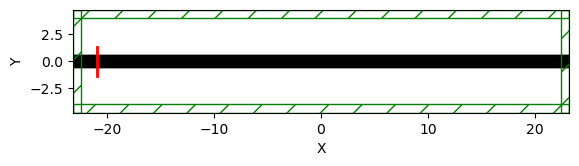

In [21]:
sim1.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sim_x,sim_y)))

In [22]:
refl=sim1.add_flux(fcen,df,nfreq,
                  mp.FluxRegion(center=minitor_1x,direction=mp.X,size=minitor_size))
tran1=sim1.add_flux(fcen,df,nfreq,
                   mp.FluxRegion(center=minitor_4x,direction=mp.X,size=minitor_size))


pt = mp.Vector3(0.5*sim_x-pml-a,0,0)
sim1.run(until=200)


straight_refl_data = sim1.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran1)

FloatProgress(value=0.0, description='0% done ', max=200.0)

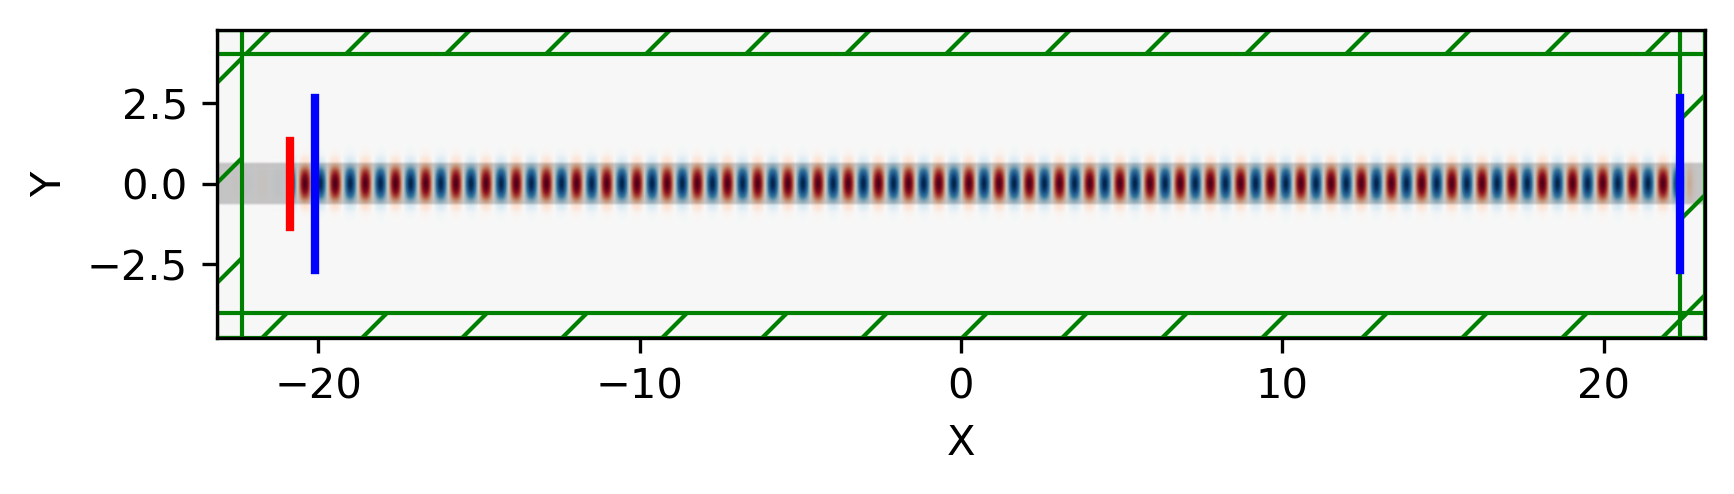

<Figure size 640x480 with 0 Axes>

In [33]:
plt.figure(dpi=300)

sim1.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sim_x,sim_y)),
           fields=mp.Ey)

plt.show()
plt.savefig('T_R_loss_1.png')

In [24]:
aa=2
geometry = [mp.Block(size=mp.Vector3(mp.inf,y_length,z_length),
                       center=mp.Vector3(block_x1,0,0),material=LN),]

geometry += [mp.Block(size=mp.Vector3(Block_x,Block_y,Block_z),
                     center=mp.Vector3(block_x+aa,block_y,block_z),material=LN)]
# geometry += [mp.Block(size=mp.Vector3(x_length,y_length,z_length),
#                       center=mp.Vector3(block_x1,0,0),material=LN),
#              mp.Block(size=mp.Vector3(x_length,y_length,z_length),
#                       center=mp.Vector3(block_x2,0,0),material=LN)]
for i in np.linspace(-x_num*0.5*a,x_num*0.5*a,x_num+1):
    for j in np.linspace(-y_num*np.sqrt(3)*a,y_num*np.sqrt(3)*a,2*y_num+1):
        if j != 0:
            geometry += [add_cylinder(mp.Vector3(i+0.5*a+aa,j,0)),
                         add_cylinder(mp.Vector3(i+aa,j+np.sqrt(3)*0.5*a,0))]
        else:
            geometry += [add_cylinder(mp.Vector3(i+aa,np.sqrt(3)*0.5*a,0))]


sim_x=x_num*a+2*x_length+pml*2

sim_x_aa=sim_x+2*aa

soc_local=mp.Vector3(-sim_x_aa/2+2,0,0 )#mp.Vector3(-0.5*a*x_num-x_length*0.5,0,0)


simulation_area=mp.Vector3(sim_x_aa,6,sim_z)

eig_sources=[mp.EigenModeSource(
    src = mp.ContinuousSource(fcen, fwidth=df),
    center=soc_local, 
    size=sources_area,
    eig_band=1,
    direction=mp.AUTOMATIC,
    eig_kpoint=mp.Vector3(1,0,0),
    eig_parity=mp.EVEN_Z+mp.ODD_Y,
    eig_match_freq=True,)]

            
sim = mp.Simulation(cell_size=simulation_area,
                    resolution=resolution,
                    boundary_layers=[mp.PML(pml)],
                    sources=eig_sources,
                    geometry=geometry,
                    #Courant=courant,
                    #symmetries=[mp.Mirror(mp.Y,phase=1),mp.Mirror(mp.Z,phase=-1)]
                    )



<Axes: xlabel='X', ylabel='Y'>

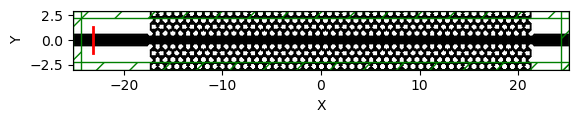

In [25]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sim_x_aa,sim_y)))

In [34]:
minitor_1x=mp.Vector3(a,0,0)+soc_local
minitor_3x=mp.Vector3(sim_x_aa/2-1,0,0)

refl=sim.add_flux(fcen,df,nfreq,
                  mp.FluxRegion(center=minitor_1x,direction=mp.X,size=minitor_size))

tran3=sim.add_flux(fcen,df,nfreq,
                   mp.FluxRegion(center=minitor_3x,direction=mp.X,size=minitor_size))
#sim.load_minus_flux_data(refl,straight_refl_data)
pt = mp.Vector3(-a,0,0)+minitor_3x

sim.run(until=300) 

pc_ref1_flux = mp.get_fluxes(refl)
pc_tran_flux = mp.get_fluxes(tran3)
flux_freqs = mp.get_flux_freqs(refl)
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -pc_ref1_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, pc_tran_flux[i] / straight_tran_flux[i])


FloatProgress(value=200.0, description='0% done ', max=500.0, min=200.0)

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


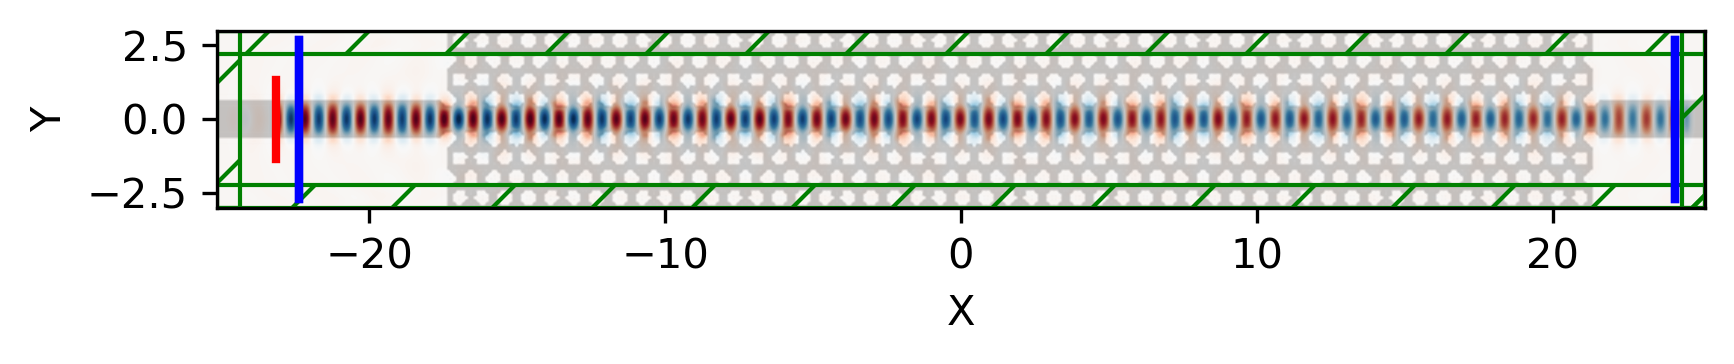

In [35]:
plt.figure(dpi=300)

sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sim_x_aa,sim_y)),
           fields=mp.Ey)
plt.show()
#plt.savefig('T_R_loss_2.png') 

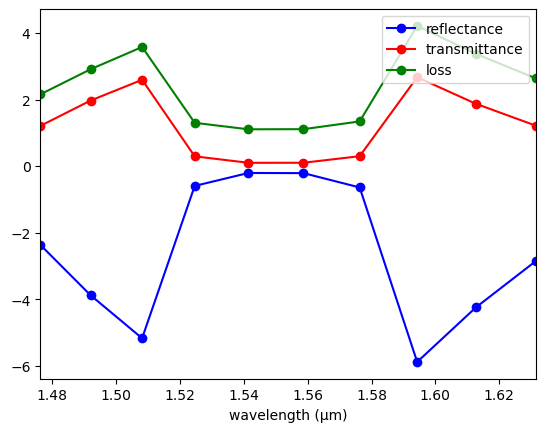

In [36]:
plt.plot(wl, Rs, "bo-", label="reflectance")
plt.plot(wl, Ts, "ro-", label="transmittance")
plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
plt.xlim(min(wl),max(wl))
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.savefig("T_R_loss.png")
plt.show()